# Supporting Notebook with analytical narratives

Imported all the libraries needed for the analysis.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt

Import the dataset for the analysis.

In [2]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

Since some attributes are categorical, we convert them into numerical in order to apply Random Forest.

For the column family_history_with_overweight, convert no to 0 and yes to 1.

Make the column name shorter for convenience.

In [3]:
df['family_history_with_overweight'] = df['family_history_with_overweight'].apply(lambda x: 0 if x == 'no' else 1)
df.rename(columns = {"family_history_with_overweight": "family_history"}, inplace = True)

For the column FAVC, convert no to 0 and yes to 1.

In [4]:
df['FAVC'] = df['FAVC'].apply(lambda x: 0 if x == 'no' else 1)

For the column SMOKE, convert no to 0 and yes to 1.

In [5]:
df['SMOKE'] = df['SMOKE'].apply(lambda x: 0 if x == 'no' else 1)

For the column SCC, convert no to 0 and yes to 1.

In [6]:
df['SCC'] = df['SCC'].apply(lambda x: 0 if x == 'no' else 1)

For the column CAEC, convert no to 0, Sometimes to 1, Frequently to 2, and Always to 3.

In [7]:
df['CAEC'] = df['CAEC'].apply(lambda x:0 if x=='no' else (1 if x=='Sometimes' else (2 if x=='Frequently' else 3)))

For the column CALC, convert no to 0, Sometimes to 1, Frequently to 2, and Always to 3.

In [8]:
df['CALC'] = df['CALC'].apply(lambda x:0 if x=='no' else (1 if x=='Sometimes' else (2 if x=='Frequently' else 3)))

For the column MTRANS, convert Automobile to 0, Motorbike to 1, Bike to 2, Public_Transportation to 3, and Walking to 4.

In [9]:
df['MTRANS'] = df['MTRANS'].apply(lambda x:0 if x=='Automobile' else (1 if x=='Motorbike' else (2 if x=='Bike' else (3 if x=='Public_Transportation' else 4))))

We split the dataset into attributes and a label, X and y, and split them into train and test sets.

During the process, we drop height and weight attributes as they are used for calculating obesity levels which are our target labels.

In [10]:
X = df.loc[:, (df.columns != 'NObeyesdad') & (df.columns != 'Height') & (df.columns != 'Weight') & (df.columns != 'Gender') & (df.columns != 'Age')]
y = df.NObeyesdad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

We conduct a hyperparameter tuning on a Random Forest model (RandomForestClassifier) using 10-fold Cross Validation (GridSearchCV) to prevent overfitting and validate the model.

Even though the two important parameters for Random Forest are the number of trees and the number of the attributes , the only hyperparameter tuned in the process was the number of trees in the forest as we needed to use all the attributes to see their feature importance.

In [11]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
param_grid = [{'n_estimators': [10,25,50,100,250,500]}]
cv_forest = GridSearchCV(clf, param_grid, cv=10)
cv_forest.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid=[{'n_estimators': [10, 25, 50, 100, 250, 500]}])

Extract the best RF model and its parameters from the result of Cross Validation for further analysis.

In [12]:
best_RF = cv_forest.best_estimator_
best_params = cv_forest.best_params_
best_params = best_params['n_estimators']

Calculate permutation importance to see which attribute was important to build the best RF model.

In [13]:
idx = X_train.columns
pimp = permutation_importance(best_RF, X_train, y_train, n_repeats=10,random_state=0)
pimp_result = pd.DataFrame(pimp.importances_mean,index=idx,columns=['feature importance'])
pimp_result = pimp_result.sort_values('feature importance',ascending=False)

visualise the result of permutation importance to interpret the result deeper.

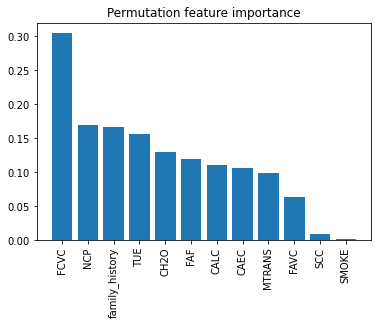

In [14]:
plt.bar(pimp_result.index,pimp_result['feature importance'])
plt.xticks(rotation='vertical')
plt.title('Permutation feature importance')
plt.show()

Visualise confusion matrix of the best RF model to see its performance.

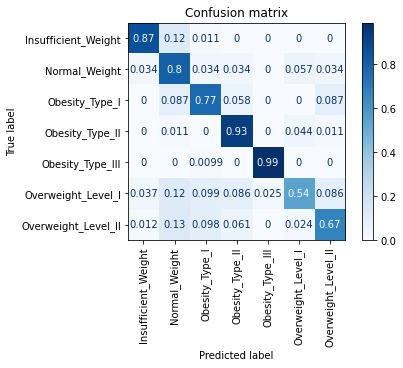

In [15]:
disp = plot_confusion_matrix(best_RF, X_test, y_test,cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical')
disp.ax_.set_title('Confusion matrix')
plt.show()

Train models on the datasets that only include physical condition or eating habits attributes to compare their performances and determine which more likely leads to obesity.

In [16]:
# train a model of physical condition
physical_condition = ['family_history','SCC','FAF','TUE','MTRANS']
X_train_PC = X_train[physical_condition]
X_test_PC = X_test[physical_condition]
clf_PC = RandomForestClassifier(n_jobs=-1,n_estimators=best_params)
clf_PC.fit(X_train_PC, y_train)

RandomForestClassifier(n_estimators=250, n_jobs=-1)

In [17]:
# train a model of eating habits
eating_habits = ['FCVC','NCP','CH2O','CAEC','FAVC','SMOKE','CALC']
X_train_EH = X_train[eating_habits]
X_test_EH = X_test[eating_habits]
clf_EH = RandomForestClassifier(n_jobs=-1,n_estimators=best_params)
clf_EH.fit(X_train_EH, y_train)

RandomForestClassifier(n_estimators=250, n_jobs=-1)

Visualise confusion matrices of the both models to see the difference of their performances.

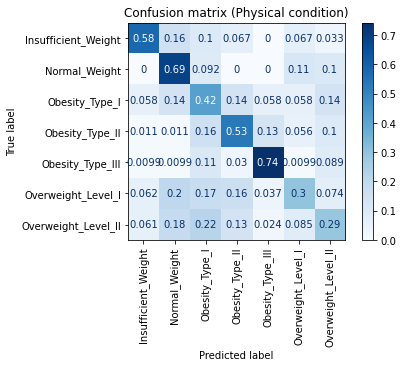

In [18]:
# visualise confusion matrix of physical condition model
disp_PC = plot_confusion_matrix(clf_PC, X_test_PC, y_test,cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical')
disp_PC.ax_.set_title('Confusion matrix (Physical condition)')
plt.show()

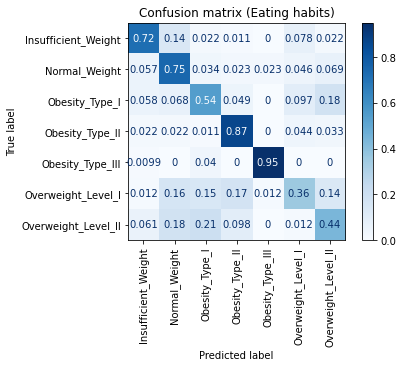

In [19]:
# visualise confusion matrix of eating habits model
disp_EH = plot_confusion_matrix(clf_EH, X_test_EH, y_test,cmap=plt.cm.Blues,normalize='true',xticks_rotation='vertical')
disp_EH.ax_.set_title('Confusion matrix (Eating habits)')
plt.show()

Calculate classification error for the best model, the model of physical conditions, and the model of eating habits.

In [20]:
accuracy = best_RF.score(X_test,y_test)
accuracy_PC = clf_PC.score(X_test_PC,y_test)
accuracy_EH = clf_EH.score(X_test_EH,y_test)
error_list = [1-accuracy,1-accuracy_PC,1-accuracy_EH]

Calculate Matthews Correlation Coefficient for the best model, the model of physical conditions, and the model of eating habits.

In [21]:
y_pred = best_RF.predict(X_test)
y_pred_PC = clf_PC.predict(X_test_PC)
y_pred_EH = clf_EH.predict(X_test_EH)
MCC = matthews_corrcoef(y_test, y_pred)
MCC_PC = matthews_corrcoef(y_test, y_pred_PC)
MCC_EH = matthews_corrcoef(y_test, y_pred_EH)
MCC_list = [MCC,MCC_PC,MCC_EH]

Visualise the classification errors and the MCCs and compare their performances to see which more likely lead to obesity, physical conditions or eating habits.

In [22]:
results = pd.DataFrame([error_list,MCC_list],columns=['all','physical condition','eating habits'],index=['error','MCC'])
results

,all,physical condition,eating habits
error,0.195584,0.485804,0.329653
MCC,0.773215,0.433466,0.616547
